# Supervised Regression (predictions of continuous data)

<i>By Diego Ramallo</i>

Here we'll try out a linear regression exercise on our own. This exercise will cover basic linear regression, ridge regression/lasso regression, and decision trees/random forests. We will be following this template: http://facweb.cs.depaul.edu/mobasher/classes/csc478/Notes/IPython%20Notebook%20-%20Regression.html

[Formatting Data](#Formatting Data)

[Visualizing data](#Visualizing Data)

[Splitting Data](#Splitting Data)

[Basic Linear Regression](#Basic Linear Regression)

[Cross-Validation](#Cross-Validation)

[Ridge Regression](#Ridge Regression)

[Lasso Regression](#Lasso Regression)


## Formatting Data

<a id='Formatting Data'></a>

In [3]:
#We'll import our sklearn model libraries
from sklearn.cross_validation import KFold, train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, SGDRegressor
import numpy as np
import pylab as pl
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
#Here we'll import our data from the sklearn library
from sklearn.datasets import load_boston

boston= load_boston()

In [5]:
#boston seems to be a dictionary, let's check the keys
#to see what kind of data we're working with
boston.keys()

['data', 'feature_names', 'DESCR', 'target']

In [6]:
#Great, we can see the relevant items for our machine learning
#tasks. Let's take data, target, and feature names
#and put them into a dataframe for easier viewing
bostonDF = pd.DataFrame(boston['data'], columns= boston['feature_names'])
bostonDF['target'] = boston['target']

In [7]:
bostonDF.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


Great now we have a dataframe with all of our features and labels on the same data structure. In our tutorial we are directed to add an extra row of ones to do multiple regression. The reason for this 'x0' ones column is that it is implicit in our function, and helps to keep it there for matrix multiplication purposes: http://stackoverflow.com/questions/32980461/matlab-linear-regression-y-intercept-by-adding-one-column-of-ones

In [8]:
#Using length of target as ref to make correct length x0 column
bostonDF['x0']= np.array(np.ones(len(bostonDF['target'])))

In [9]:
#Let's get a look at some of our data
bostonDF.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target,x0
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0,1.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6,1.0
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7,1.0
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4,1.0
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2,1.0


In [10]:
#Now let's get a description of our dataset
bostonDF.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target,x0
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.0
mean,3.593761,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806,1.0
std,8.596783,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104,0.0
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000,1.0
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000,1.0
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000,1.0
75%,3.647423,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000,1.0
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000,1.0


In [14]:
def onevsallPlot(dataf, target):
    '''This is like the seaborn pairgrid plot (all vs all) 
    except that it only plots the features against a single
    feature (eg. target column).'''
    
    #We will first remove non-numeric columns from our dataframe
    dataNum= dataf._get_numeric_data()
    
    #Get remaining column names
    feats= dataNum.ix[:, dataNum.columns != target].columns
    
    #Get # of features to specify # of plots to generate
    numFeats= len(feats)
    
    #Using 5 columns since that's max visible in cell at 10x6 dimension
    gridCols= 5
    
    #Making # of rows 1 larger than necessary so we always have space
    #to fill remaining plots (if numFeats%gridCols != 0)
    gridRows= (numFeats//gridCols)+1
    
    #Initialize figure and axes objects
    figure, ax = plt.subplots(1,1, figsize=(10,6))
    
    #Iterate through each feature 
    for i in range(1, len(feats)):
            #Specify index of subplot in gridRows x gridCols grid
            plt.subplot(gridRows, gridCols, i)
            
            #Plot feature vs target
            plt.scatter(dataNum[feats[i]], dataNum[target], 
                marker= '.', color= '#0099ff')
            
            #Set title
            plt.title(feats[i] + ' vs ' + dataNum[target].name, fontsize= 10, fontweight= 'bold')
            
            #Set axes, limit ticks
            plt.locator_params(axis='x',nbins=4)
            plt.locator_params(axis='y',nbins=4)
            plt.tight_layout()

## Visualizing Data

<a id='Visualizing Data'></a>

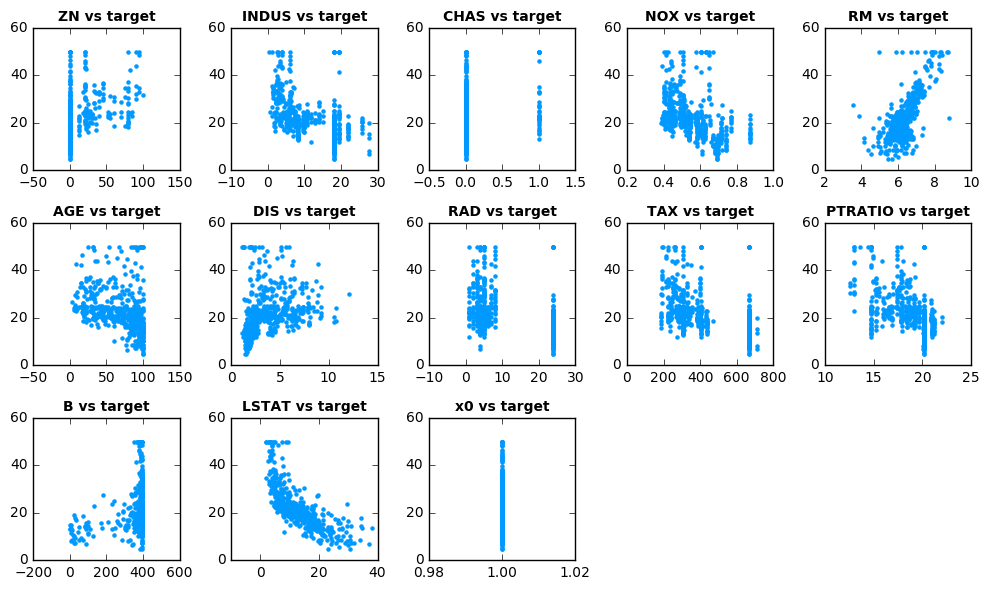

In [16]:
%matplotlib inline
onevsallPlot(bostonDF, 'target')

Excellent, it looks as if at least a few of our features have a positive or negative correlation with 'target' (RM, DIS). As we test out a few of our regression algorithms, we'll identify which features are most essential for predicting the values of our target variable.

Now we'll split our data in order to perform basic linear regression on a training set and then measuring performance on a test set.

## Splitting Data

<a id='Splitting Data'></a>

In [31]:
#Now we'll split our data first into training/testing (wel'll further divide testing into validation, real test)
#random_state sets seed

train, test= train_test_split(bostonDF, test_size= 0.3, random_state= 42)

## Basic Linear Regression

<a id='Basic Linear Regression'></a>

Before implementing the model, it's important to mention that to initially weigh all of our features equally we need to <strong>standardize/scale</strong> them. SKLearn has a module for scaling (preprocessing.scale) so notice that during most of my fits I'll be applying this operation to our dataframes.

In [32]:
#We'll start with linear regression before optimization
linReg0= LinearRegression()

In [33]:
#Now we'll fit our data using our features (all cols but 'target') and our response ('target')
from sklearn import preprocessing

linReg0.fit(preprocessing.scale(train.ix[:, train.columns != 'target']), train['target'])# First argument selects everything but target column

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [34]:
#Now that' we have model, we can predict values using our validation set features

predTest= linReg0.predict(preprocessing.scale(test.ix[:, test.columns != 'target']))

In [38]:
#Now we can calculate our error 

absErr = abs(predTest-test['target'])
MSE= sum(absErr**2)/len(predVal)
rootMSE= np.sqrt(MSE)
#Could also take the dot product of
#error with itself to give us the sum of squared errors (next commented lines)

#new= np.dot(absErr,absErr)
#np.sqrt(new/len(predVal))

#Let's also look at the median value for the true values

print 'The RMSE error metrics for the test set is {}'.format(rootMSE)

The RMSE error metrics for the test set is 4.91398799492


Excellent, our rootMSE variable will be our error metric for linear regression.

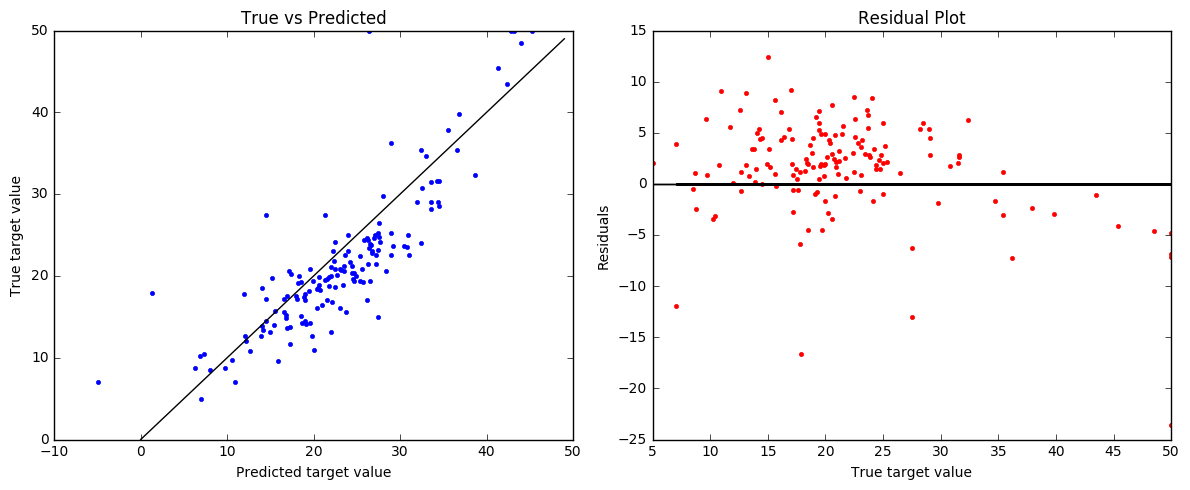

In [109]:
#We can plot the results of the predictions against the real values
#Good predictions should show a linear relationship with true values
%matplotlib inline

figure, ax = plt.subplots(1,1, figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(predTest, test['target'], '.')
plt.plot(range(0,50),range(0,50), 'k-')#Plots ideal reference where y=x
plt.xlabel('Predicted target value')
plt.ylabel('True target value')
plt.title('True vs Predicted')

#Additionally, a residuals (predicted-true response) plot will tell us how far our predictions
#were from our test responses

plt.subplot(1,2,2)
plt.plot(test['target'], predTest-test['target'], '.r')
plt.plot(test['target'], np.zeros(len(test['target'])), 'k-')
plt.xlabel('True target value')
plt.ylabel('Residuals')
plt.title('Residual Plot')

plt.tight_layout()

In [124]:
#Let's calculate the R-squared value for the plot on the left
import scipy
_, _, r_value, _, _ = scipy.stats.linregress(predTest, test['target'])
print 'R-squared value: ', r_value**2#Squares r-value
print 'Coefficient values: ', linReg0.coef_

R-squared value:  0.722032199578
Coefficient values:  [-1.67172368  1.0267518   0.35737787  0.47912616 -1.73037142  3.34198991
  0.07377253 -2.73663728  4.00338434 -2.62205603 -1.75457146 -0.19896714
 -3.79182132  0.        ]


As you can see from the 'True vs Predicted' plot, we only really get values close to the True target values near the center of our target range. Our R-squared score of 0.75 also shows a weaker correlation than we'd like (something closer to 1.0 would be preferable). 

Our 'Residual Plot' confirms this by showing that the difference between our predicted and true values can be quite large for some observations than for others. The residual plot also doesn't look random indicating that there may be some heteroskedasticity (the variance of our errors is not constant across observations). The implication being that there may be some information in my system that I'm not including in my model (there may be a better estimator than just linear regression with OLS).

## Cross-Validation

<a id='Cross-Validation'></a>

Now we'll test the performance of our linear regression by training on different randomized subsets of our combined training and validation sets. 

In [56]:
#Ok first we'll make a copy of our bostonDF dataframe to apply CV to it
cvData= bostonDF.copy()
cvData.head(3)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target,x0
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0,1.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6,1.0
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7,1.0


In [99]:
#Now we'll use these arrays to define the K-Fold splits. The number determines the amount of
#bias and variance you'd like in your predictions. Typically, larger folds is better if you have 
#enough samples. Since we have less than 500 here, I'll keep it at 5 (3, 5, or 10 are common)

cvDataX= np.array(preprocessing.scale(cvData.ix[:, cvData.columns != 'target']))
cvDataY= np.array(cvData['target'])

kf= KFold(len(cvData), n_folds= 5, shuffle= False, random_state= 42)
kf

sklearn.cross_validation.KFold(n=506, n_folds=5, shuffle=False, random_state=42)

In [100]:
#Now we'll apply the same error estimation that we did before to each split
#Initialize list to hold rmse scores
rmseList= []

#Apply linear regression to each fold, predict and calculate RMSE
for trainKF, testKF in kf:
    
    #Train on a subset of training/val set using the training indices of different folds
    linReg0= LinearRegression()
    linReg0.fit(np.array(cvDataX)[trainKF], cvDataY[trainKF])
    
    #Predict on a subset of data using the test indices
    predKF= linReg0.predict(cvDataX[testKF])
    
    #Calculate error from predicted values and testing indices
    kfError= predKF-cvDataY[testKF]#These indices may not make sense cause we
    
    #Calculate the RMSE and append to our list of RMSE's
    #rmseKF=  np.sqrt(np.mean(kfError**2))
    rmseKF= np.sqrt(np.dot(kfError,kfError)/len(predKF))
    print 'RMSE: ', rmseKF
    rmseList.append(rmseKF)
    
rmseAverageKF= np.mean(rmseList)
print 'Our mean RMSE from K-Fold validation is: ', rmseAverageKF

RMSE:  3.53279637288
RMSE:  5.10844425141
RMSE:  5.75499399415
RMSE:  8.99072042601
RMSE:  5.79520108817
Our mean RMSE from K-Fold validation is:  5.83643122652


In [102]:
#Let's compare this to what we got by training on the train set and testing on the validation set
print 'RMSE single fold: ', rootMSE
print 'RMSE k-fold: ', rmseAverageKF

RMSE single fold:  4.91398799492
RMSE k-fold:  5.83643122652


Interesting, our RMSE didn't really go down but it did show that we're somewhat sensitive to the training set subset that we choose to train the model (not very consisten, a lot of variance). 

Thus, let's see how much we can improve this by reducing the variance with regularization: L1 (Lasso) regression, and L2 (Ridge) regression methods. 

## Ridge Regression

<a id='Ridge Regression'></a>

Just as an overview, Ridge Regression adds an extra term to our RSS equation that adds additional coefficient estimates. As our tuning parameter <i>alpha</i> increases, the value of the coefficients approach zero. When <i>alpha</i> is large, the coefficients approach 0. Also, <i>alpha</i> does not affect the intercept coefficient (typically beta-0). 

An <i>alpha</i> of zero will yield betas of the same value of linear regression with high variance and low bias, and as <i>alpha</i> grows, it will result in a decrease in variance and higher bias. Finally, Ridge typically performs better when you expect that the coefficients are of similar magnitude. 

Since we don't know what our optimal <i>alpha</i> value will be, we'll need to test a bunch of values across different size scales and find which one is optimal. Luckily, SKLearn has a version of Ridge (RidgeCV) that includes cross-validation that will allow us to do that. We'll just need to set number of alphas (numAlphas) to try and the range (alphaList) that they'll cover first.

In [82]:
from sklearn import linear_model
#Now let's set the number of alphas we'll test along with its range
numAlphas= 100
alphaList= np.logspace(0.01,10,numAlphas)

#Initialize Ridge object and perform CV over numAlpha iterations
ridge0= linear_model.RidgeCV(alphas= alphaList)
ridge0.fit(cvDataX, cvDataY)

print 'Your optimal alpha is: ', ridge0.alpha_

Your optimal alpha is:  1.02329299228


Now let's implement this on our testing set to get an out of sample accuracy score.

In [94]:
#First train on your training set again using the optimal alpha
#(see 'Splitting Data section')

ridgeFinal= linear_model.Ridge(alpha = ridge0.alpha_)
ridgeFinal.fit(preprocessing.scale(train.ix[:, train.columns != 'target']), train['target'])

Ridge(alpha=1.0232929922807541, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

In [103]:
#Now predict (preprocess features like in linear reg. and cv)
predRidge= ridgeFinal.predict(preprocessing.scale(test.ix[:, test.columns != 'target']))

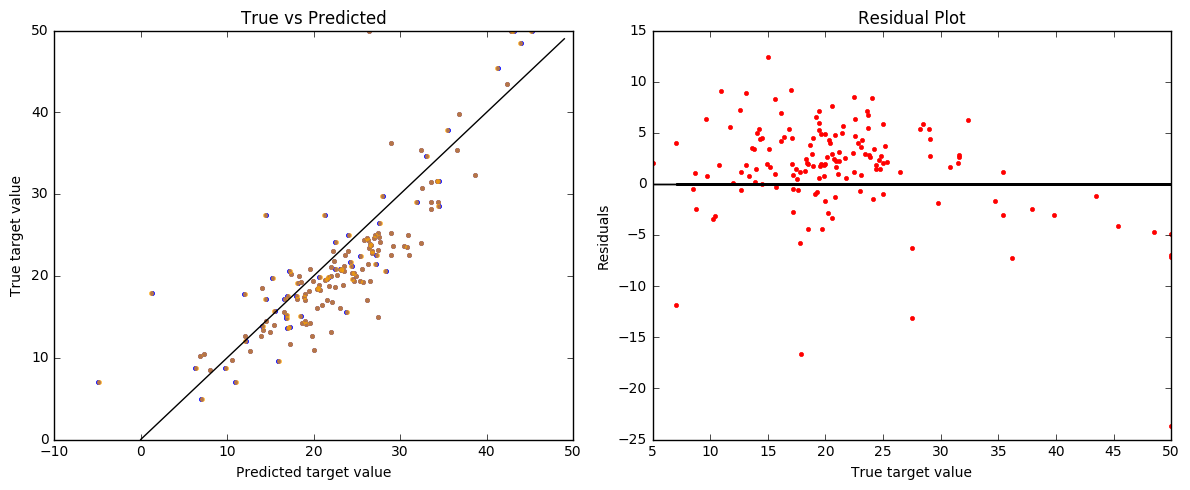

In [115]:
#Now let's plot those predicted vs true and residual figures again

figure, ax = plt.subplots(1,1, figsize=(12,5))

plt.subplot(1,2,1)

#First plot the regular linear regression fits in blue
plt.plot(predTest, test['target'], '.')

#Now plot the results of our Ridge Regression in orange
plt.plot(predRidge, test['target'], '.', color= 'orange', alpha= 0.7)
plt.plot(range(0,50),range(0,50), 'k-')#Plots ideal reference where y=x
plt.xlabel('Predicted target value')
plt.ylabel('True target value')
plt.title('True vs Predicted')

#Additionally, a residuals (predicted-true response) plot will tell us how far our predictions
#were from our test responses

plt.subplot(1,2,2)
plt.plot(test['target'], predRidge-test['target'], '.r')
plt.plot(test['target'], np.zeros(len(test['target'])), 'k-')
plt.xlabel('True target value')
plt.ylabel('Residuals')
plt.title('Residual Plot')

plt.tight_layout()

In [117]:
#Calculate RMSE again
ridgeRMSE= np.sqrt(sum((predRidge-test['target'])**2)/len(predRidge))
print 'Linear regression RMSE (single fold) is: ', rootMSE
print "RidgeCV's RMSE is: ", ridgeRMSE

Linear regression RMSE (single fold) is:  4.91398799492
RidgeCV's RMSE is:  4.9165041686


In [106]:
_, _, ridgeR_value, _, _ = scipy.stats.linregress(predRidge, test['target'])
print 'R-squared value: ', ridgeR_value**2#Squares r-value

R-squared value:  0.721241268493


In [123]:
#Finally, let's look at our coefficient values
ridgeFinal.coef_

array([-1.08886691,  0.78712226,  0.31636464,  0.81993599, -1.76673856,
        2.91409853, -0.29982088, -2.90348031,  2.00776766, -1.37278141,
       -2.04356427,  1.03368552, -3.8775664 ,  0.        ])

Interesting, so the performance of the Ridge didn't help out much here. It's almost identical to what it was with regular linear regression. We'll try Lasso Regression, but I'm starting to suspect that there is nonlinearity in our features that may not improve our fits even with regularization methods.

## Lasso Regression

<a id='Lasso Regression'></a>

Unlike with Ridge Regression, the Lasso regularization method will make the values of some of our betas <strong>equal</strong> to zero, thus trimming the number of features in our model. 

Like with Ridge, SKLearn has a version of Lasso that comes with a version that includes cross-validation to tune the alpha hyperparameter. 

In [136]:
from sklearn import linear_model
#Now let's set the number of alphas we'll test along with its range
numAlphas= 100
alphaList= np.logspace(0,1,numAlphas)
lasso0= linear_model.LassoCV(alphas= alphaList)
lasso0.fit(cvDataX, cvDataY)

print 'Your optimal alpha is: ', lasso0.alpha_

Your optimal alpha is:  1.0


In [137]:
#Again, we'll use this LassoCV alpha value to implement it into a regular Lasso regression

lassoFinal= linear_model.Lasso(alpha = lasso0.alpha_)
lassoFinal.fit(preprocessing.scale(train.ix[:, train.columns != 'target']), train['target'])

#Now predict (preprocess features like in linear reg. and cv)
predLasso= lassoFinal.predict(preprocessing.scale(test.ix[:, test.columns != 'target']))

In [138]:
#Calculate Lasso RMSE 
lassoRMSE= np.sqrt(sum((predLasso-test['target'])**2)/len(predLasso))
print 'Linear regression RMSE (single fold) is: ', rootMSE
print "RidgeCV's RMSE is: ", ridgeRMSE
print "LassoCV's RMSE is: ", lassoRMSE

print 'Lasso coefficients are: ', lassoFinal.coef_

Linear regression RMSE (single fold) is:  4.91398799492
RidgeCV's RMSE is:  4.9165041686
LassoCV's RMSE is:  5.32847731609
Lasso coefficients are:  [-0.          0.         -0.          0.22497432 -0.          2.73101835
 -0.         -0.         -0.         -0.         -1.24748149  0.26711055
 -3.75408478  0.        ]


Interesting, when I used the range to explore the alphaList (-10,10), my alpha ended up being 0.019, my RMSE was close to 4.923 similar to linReg and ridgeReg, but the coefficients were all greater than 0. However, when I changed the alphaList range to 0 and 1, my optimal alpha became 1, my RMSE went up to 5.3 but some of my coefficients went down to 0.

## Principal Component Regression (PCA + Linear Regression)

## Random Forest

In [71]:
train2X

array([[ 0.36480028, -0.51555608,  0.98572244, ..., -0.54400037,
         1.62849278,  0.        ],
       [-0.40938646,  2.42360314, -1.26202295, ...,  0.1829827 ,
        -1.10236752,  0.        ],
       [-0.40961735, -0.51555608,  0.39331539, ...,  0.40766928,
        -0.72856691,  0.        ],
       ..., 
       [-0.41434614,  2.84348303, -1.29461951, ...,  0.38749291,
        -0.92604648,  0.        ],
       [ 0.94716859, -0.51555608,  0.98572244, ..., -2.58181356,
         1.51141561,  0.        ],
       [-0.38823456, -0.51555608, -0.36632618, ..., -2.99431994,
        -0.27154277,  0.        ]])

In [85]:
#Sometimes we get these errors from converting a dataframe to an array. The np.asarray command should fix this
from sklearn.ensemble import RandomForestClassifier

randfor= RandomForestClassifier(n_estimators= 100)
forfit= randfor.fit(preprocessing.scale(train.ix[:, train.columns != 'target']), np.asarray(train['target'], dtype="|S6"))
forpred= forfit.predict(preprocessing.scale(test.ix[:, test.columns != 'target']))

In [87]:
#Now let's get the list of variable importance from our fit. Larger numbers = greater importance
importances = randfor.feature_importances_

In [92]:
importanceDF= pd.DataFrame()
importanceDF['features']= test.ix[:, test.columns != 'target'].columns
importanceDF['importance']= importances
importanceDF

,features,importance
0,CRIM,0.120444
1,ZN,0.023059
2,INDUS,0.054061
3,CHAS,0.011976
4,NOX,0.080589
5,RM,0.128715
6,AGE,0.111367
7,DIS,0.105385
8,RAD,0.039760
9,TAX,0.054413


In [105]:
rankImportance= importanceDF.sort_values(by='importance', ascending= False)

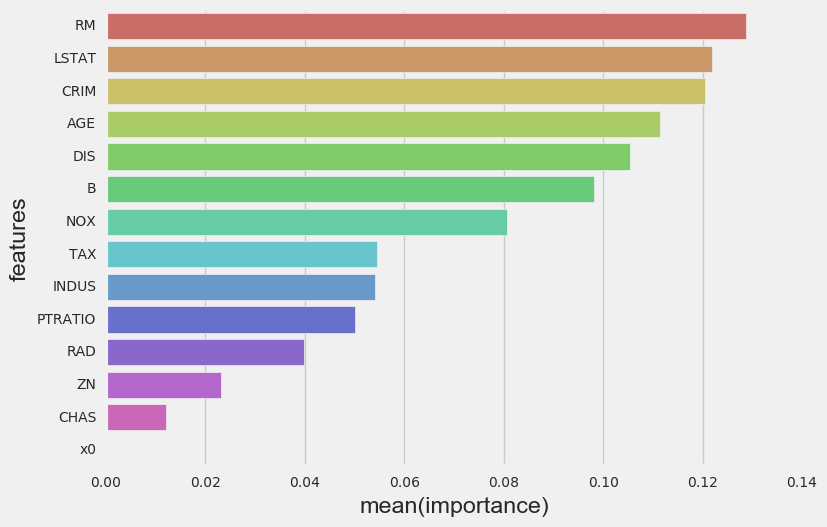

In [112]:
import seaborn as sns
sns.barplot(y="features", x="importance", data=rankImportance, palette= 'hls')

[1, 2, 0, 0, 0]

In [118]:
ridgeRMSE

4.9165041686035797

In [26]:
print backzeros([5,0,2,0,4])

[5, None, 2, 0, 0]
